# Final TP - NLP
## Classification des documents du procès des groupes américains du tabac

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split

In [3]:
path = "Tobacco3482-OCR/"
classes = os.listdir(path)

nb = []
x = []
y = []
for cls in classes:
    files = os.listdir(path + cls)
    for file in files:
        with open(path + cls + "/" + file, 'r') as f:
            txt = f.read()
        x.append(txt)
        y.append(cls)
    nb.append(str(len(files)))
print(str(nb))
x = np.array(x)
y = np.array(y)
#print(np.unique(y))

['120', '265', '620', '599', '261', '567', '230', '431', '188', '201']


In [4]:
# To replace the \n with space
for i in range(x.shape[0]):
    x[i] = x[i].replace("\n", " ")

(array([1582., 1145.,  449.,  132.,   66.,   60.,   30.,   11.,    3.,
           4.]),
 array([   0. ,  157.9,  315.8,  473.7,  631.6,  789.5,  947.4, 1105.3,
        1263.2, 1421.1, 1579. ]),
 <a list of 10 Patch objects>)

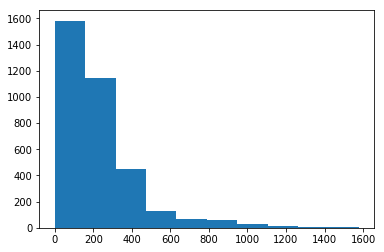

In [231]:
# Histogram of texts' lengthes
x_token = []
for text in x:
    tokens = text.split()
    x_token.append(tokens)
#print(x[0])
#print(x_token[0])
lengthes = []
for i in range(len(x)):
    lengthes.append(len(x_token[i]))
plt.hist(lengthes)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
# Create document vectors
# YOUR CODE HERE
vectorizer = CountVectorizer(max_features=2000)
vectorizer.fit(x_train)
x_train_counts = vectorizer.transform(x_train)
x_test_counts = vectorizer.transform(x_test)

from sklearn.feature_extraction.text import TfidfTransformer
# With TF-IDF representation
tf_transformer = TfidfTransformer()
tfidf = tf_transformer.fit(x_train_counts)
x_train_tf = tfidf.transform(x_train_counts)
x_test_tf = tfidf.transform(x_test_counts)


## Naive Bayes Classifier

In [17]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(x_train_tf, y_train)
res = clf.score(x_test_tf, y_test)
print('Accuray of NB: ' + str(res))

Accuray of NB: 0.6944045911047346


In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# YOUR CODE HERE
y_pred = clf.predict(x_test_tf)
report = classification_report(y_test, y_pred)
print(report)
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

               precision    recall  f1-score   support

Advertisement       0.73      0.49      0.59        45
        Email       0.91      0.95      0.93       128
         Form       0.69      0.80      0.74        96
       Letter       0.58      0.77      0.66       104
         Memo       0.54      0.87      0.66       119
         News       0.80      0.53      0.64        30
         Note       0.50      0.03      0.05        40
       Report       1.00      0.06      0.11        50
       Resume       1.00      0.97      0.98        31
   Scientific       0.81      0.56      0.66        54

    micro avg       0.69      0.69      0.69       697
    macro avg       0.76      0.60      0.60       697
 weighted avg       0.73      0.69      0.66       697

[[ 22   2   3   7  10   0   1   0   0   0]
 [  0 122   0   4   2   0   0   0   0   0]
 [  1   1  77   5  12   0   0   0   0   0]
 [  0   1   0  80  22   0   0   0   0   1]
 [  0   2   2  10 103   0   0   0   0   2]
 [  4   0   

In [19]:
import ast
import os
from nn_utils import TrainingHistory
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, Dropout, MaxPooling1D, Conv1D, Flatten, Reshape
from keras.models import Model
import numpy as np
import itertools
from keras.utils import np_utils
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support, 
                             accuracy_score)

from keras.preprocessing import text, sequence

Using TensorFlow backend.


## CNN avec représentation TF-IDF

In [22]:
# Model parameters
MAX_FEATURES = 10000
MAX_TEXT_LENGTH = 2000
#EMBED_SIZE  = 300
BATCH_SIZE = 16
EPOCHS = 20
VALIDATION_SPLIT = 0.1
NB_CLASS = len(np.unique(y_train))

In [26]:
x_train_tf = x_train_tf.toarray()
x_train_tf = np.reshape(x_train_tf, (x_train_tf.shape[0], x_train_tf.shape[1], 1))
x_test_tf = x_test_tf.toarray()
x_test_tf = np.reshape(x_test_tf, (x_test_tf.shape[0], x_test_tf.shape[1], 1))

In [27]:
def get_model():

    inp = Input(shape=(MAX_TEXT_LENGTH,1))
    #model = Embedding(MAX_FEATURES, EMBED_SIZE)(inp)
    model = Dropout(0.5)(inp)
    model = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dense(1024, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(NB_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


def train_fit_predict(model, x_train, x_test, y, history):
    
    model.fit(x_train, y,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1,
              validation_split=VALIDATION_SPLIT)

    return model.predict(x_test)


# Get the list of different classes
CLASSES_LIST = np.unique(y_train)
n_out = len(CLASSES_LIST)
print(CLASSES_LIST)

# Convert clas string to index
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(CLASSES_LIST)
y_train = le.transform(y_train) 
y_test = le.transform(y_test) 
train_y_cat = np_utils.to_categorical(y_train, n_out)

# get the textual data in the correct format for NN
#x_vec_train, x_vec_test = get_train_test(x_train, x_test)
#print(len(x_vec_train), len(x_vec_test))

# define the NN topology
model = get_model()

# Define training procedure
history = TrainingHistory(x_test_tf, y_test, CLASSES_LIST)

# Train and predict
y_predicted = train_fit_predict(model, x_train_tf, x_test_tf, train_y_cat, history).argmax(1)


print("Test Accuracy:", accuracy_score(y_test, y_predicted))

p, r, f1, s = precision_recall_fscore_support(y_test, y_predicted, 
                                              average='micro',
                                              labels=[x for x in 
                                                      np.unique(y_train) 
                                                      if x not in ['CSDECMOTV']])

print('p r f1 %.1f %.2f %.3f' % (np.average(p, weights=s)*100.0, 
                                 np.average(r, weights=s)*100.0, 
                                 np.average(f1, weights=s)*100.0))


print(classification_report(y_test, y_predicted, labels=[x for x in 
                                                       np.unique(y_train) 
                                                       if x not in ['CSDECMOTV']]))

['Advertisement' 'Email' 'Form' 'Letter' 'Memo' 'News' 'Note' 'Report'
 'Resume' 'Scientific']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2000, 1)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 64)          192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1000, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              65537024  
_______________________________________________

## CNN une matrice d’embedding basée sur TF-IDF

In [159]:
from sklearn.feature_extraction.text import CountVectorizer
# Create document vectors
# YOUR CODE HERE
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(x_train)
x_train_counts = vectorizer.transform(x_train)
x_test_counts = vectorizer.transform(x_test)

from sklearn.feature_extraction.text import TfidfTransformer
# With TF-IDF representation
tf_transformer = TfidfTransformer()
tfidf = tf_transformer.fit(x_train_counts)
x_train_tf = tfidf.transform(x_train_counts)
x_test_tf = tfidf.transform(x_test_counts)

# Use x_train_tf as the embedding matrix
embedding_matrix = x_train_tf.toarray().T

In [120]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_WORDS)

    tokenizer.fit_on_texts(list(train_raw_text))
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH)



def get_model_1(embedding_matrix):

    inp = Input(shape=(MAX_TEXT_LENGTH,))
    model = Embedding(MAX_WORDS,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    model = Dropout(0.5)(model)
    model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Dropout(0.5)(model)
    model = Flatten()(model)
    model = Dense(1024, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(NB_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [121]:
EMBED_SIZE = len(x_train)
MAX_WORDS = 10000

x_vec_train, x_vec_test = get_train_test(x_train, x_test)
model = get_model_1(embedding_matrix)

# Define training procedure
history = TrainingHistory(x_vec_test, y_test, CLASSES_LIST)

# Train and predict
y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat, history).argmax(1)


print("Test Accuracy:", accuracy_score(y_test, y_predicted))

p, r, f1, s = precision_recall_fscore_support(y_test, y_predicted, 
                                              average='micro',
                                              labels=[x for x in 
                                                      np.unique(y_train) 
                                                      if x not in ['CSDECMOTV']])

print('p r f1 %.1f %.2f %.3f' % (np.average(p, weights=s)*100.0, 
                                 np.average(r, weights=s)*100.0, 
                                 np.average(f1, weights=s)*100.0))


print(classification_report(y_test, y_predicted, labels=[x for x in 
                                                       np.unique(y_train) 
                                                       if x not in ['CSDECMOTV']]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 2000)              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 2000, 2785)        27850000  
_________________________________________________________________
dropout_24 (Dropout)         (None, 2000, 2785)        0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 2000, 32)          178272    
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1000, 32)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 1000, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 32000)             0         
__________

/home/yibing/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:182: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


ValueError: Mix of label input types (string and number)

### Neural network with embedding matrix given by word2Vec

In [7]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [8]:
# Copy all the texts into one file
path = "Tobacco3482-OCR/"
classes = os.listdir(path)

text = open('text_pure_nolabel.txt', 'a')
for cls in classes:
    files = os.listdir(path + cls)
    for file in files:
        with open(path + cls + "/" + file, 'r') as f:
            txt = f.read()
            txt = txt.replace("\n", " ")
            text.writelines((txt,'\n'))
text.close()

In [9]:
file_path = 'text_pure_nolabel.txt'

# Skipgram model
#tic = time.time()
model_word2vec = Word2Vec(LineSentence(file_path), workers=4, sg=1, size=150, iter=100)
#toc = time.time()
#print("Time used to train a word2vec_skipgram word representation model: " + str(toc - tic) + "s")

# Sauvegarder le modèle et les vecteurs entraînés
model_word2vec.save('word2vec_skip.model')
model_word2vec.wv.save_word2vec_format('word2vec_skip.txt', binary = False)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/yibing/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-fb79bc46a04e>", line 5, in <module>
    model_word2vec = Word2Vec(LineSentence(file_path), workers=4, sg=1, size=150, iter=100)
  File "/home/yibing/.local/lib/python3.6/site-packages/gensim/models/word2vec.py", line 767, in __init__
    fast_version=FAST_VERSION)
  File "/home/yibing/.local/lib/python3.6/site-packages/gensim/models/base_any2vec.py", line 763, in __init__
    end_alpha=self.min_alpha, compute_loss=compute_loss)
  File "/home/yibing/.local/lib/python3.6/site-packages/gensim/models/word2vec.py", line 892, in train
    queue_factor=queue_factor, report_delay=report_delay, compute_loss=compute_loss, callbacks=callbacks)
  File "/home/yibing/.local/lib/python3.6/site-packages/gensim/models/base_any2vec.py", line 1081, in train
    **kwargs)
  File "/

KeyboardInterrupt: 

In [10]:
# Model parameters
MAX_TEXT_LENGTH = 500
MAX_WORDS = 10000
EMBED_SIZE = 150
BATCH_SIZE = 16
EPOCHS = 10
VALIDATION_SPLIT = 0.1
NB_CLASS = len(np.unique(y_train))

In [11]:
def get_embedding_index(vectors_file_path):
    embeddings_index = {}
    with open(vectors_file_path, 'r') as f:
        first_line = f.readline()
        #print(first_line)
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            
    print('Found %s word vectors.' % len(embeddings_index))
    
    return embeddings_index


def get_embedding_matrix(word_index, embedding_index):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    print('Embedding matrix built.')        
    return embedding_matrix

In [12]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_WORDS)

    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH), \
           word_index


def get_model_2(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    
    model = Dropout(0.5)(model)
    model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Dropout(0.5)(model)
    model = Flatten()(model)
    model = Dense(1024, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(NB_CLASS, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_sum:
        model.summary()
    return model

In [13]:

x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test)

vectors_file_path = 'word2vec_skip.txt'
embedding_index = get_embedding_index(vectors_file_path)
embedding_matrix = get_embedding_matrix(word_index, embedding_index)
print('Building model...')

#x_vec_train, x_vec_test = get_train_test(x_train, x_test)
model = get_model_2(embedding_matrix, word_index)

history = TrainingHistory(x_vec_test, y_test, CLASSES_LIST)
y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat, history).argmax(1)

print("Test Accuracy:", accuracy_score(y_test, y_predicted))

p, r, f1, s = precision_recall_fscore_support(y_test, y_predicted, 
                                              average='micro',
                                              labels=[x for x in 
                                                      np.unique(y_train) 
                                                      if x not in ['CSDECMOTV']])

print('p r f1 %.1f %.2f %.3f' % (np.average(p, weights=s)*100.0, 
                                 np.average(r, weights=s)*100.0, 
                                 np.average(f1, weights=s)*100.0))


print(classification_report(y_test, y_predicted, labels=[x for x in 
                                                       np.unique(y_train) 
                                                       if x not in ['CSDECMOTV']]))

AttributeError: '_io.TextIOWrapper' object has no attribute 'Tokenizer'